<a href="https://colab.research.google.com/github/Syilun/ML-Visualization/blob/master/Grad_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

import cv2
from keras import backend as K
from keras.preprocessing import image
from keras.applications import imagenet_utils
from keras.applications.resnet50 import ResNet50, preprocess_input
from matplotlib import pyplot as plt
import numpy as np
import random

Using TensorFlow backend.


In [ ]:
def processing_image(img_path):
    img = cv2.imread(img_path)[:,:,::-1]
    img = cv2.resize(img, (224,224))
    x = np.expand_dims(img, axis=0)
    
    # 將 RBG 轉換為 BGR，並解減去各通道平均
    x = preprocess_input(x)
    return x

In [ ]:
def gradcam(model, x):
    # 取得影像的分類類別
    preds = model.predict(x)
    pred_class = np.argmax(preds[0])

    # 取得影像分類名稱
    pred_class_name = imagenet_utils.decode_predictions(preds)[0][0][1]

    # 預測分類的輸出向量
    pred_output = model.output[:, pred_class]

    # 最後一層 convolution layer 輸出的 feature map
    # ResNet 的最後一層 convolution layer
    last_conv_layer = model.get_layer('add_16')

    # 求得分類的神經元對於最後一層 convolution layer 的梯度
    grads = K.gradients(pred_output, last_conv_layer.output)[0]
    print('grads ', grads.shape)
    # 求得針對每個 feature map 的梯度加總
    pooled_grads = K.sum(grads, axis=(0, 1, 2))
    print('pooled_grads', pooled_grads.shape)
    # K.function() 讓我們可以藉由輸入影像至 `model.input` 得到 `pooled_grads` 與
    # `last_conv_layer[0]` 的輸出值，像似在 Tensorflow 中定義計算圖後使用 feed_dict
    # 的方式。
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

    # 傳入影像矩陣 x，並得到分類對 feature map 的梯度與最後一層 convolution layer 的 
    # feature map
    pooled_grads_value, conv_layer_output_value = iterate([x])

    # 將 feature map 乘以權重，等於該 feature map 中的某些區域對於該分類的重要性
    for i in range(pooled_grads_value.shape[0]):
        conv_layer_output_value[:, :, i] *= (pooled_grads_value[i])
        
    # 計算 feature map 的 channel-wise 加總
    heatmap = np.sum(conv_layer_output_value, axis=-1)

    return heatmap, pred_class_name


In [ ]:
def plot_heatmap(heatmap, img_path, pred_class_name):
    # ReLU
    heatmap = np.maximum(heatmap, 0)
    
    # 正規化
    heatmap /= np.max(heatmap)
    
    # 讀取影像
    img = cv2.imread(img_path)
    
    fig, ax = plt.subplots()
    
    im = cv2.resize(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB), (img.shape[1], img.shape[0]))

    # 拉伸 heatmap
    print('heatmap', heatmap.shape)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    heatmap = np.uint8(255 * heatmap)
    
    # 以 0.6 透明度繪製原始影像
    ax.imshow(im, alpha=0.6)
    
    # 以 0.4 透明度繪製熱力圖
    ax.imshow(heatmap, cmap='jet', alpha=0.4)
    
    plt.title(pred_class_name)
    
    plt.show()

In [ ]:
model = ResNet50(weights='imagenet')
model.summary()


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

A local file was found, but it seems to be incomplete or outdated because the md5 file hash does not match the original value of a7b3fe01876f51b976af0dea6bc144eb so we will re-download the data.
102858752/102853048 [==============================] - 8s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 

grads  (?, 7, 7, 2048)
pooled_grads (2048,)
Siberian_husky /content/drive/My Drive/class/勞動部/week10/img/husky2.jpeg (7, 7) float32
heatmap (7, 7)


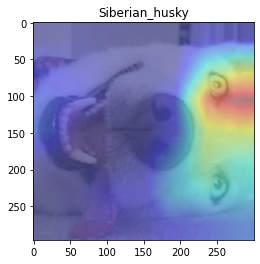

In [ ]:
i = random.choice(range(1,4))
i=2
img_path = f'/content/drive/My Drive/class/勞動部/week10/img/husky{i}.jpeg'
# img_path = f'/content/drive/My Drive/class/勞動部/week10/img/cock1.jpeg'
# img_path = f'/content/drive/My Drive/class/勞動部/week10/img/tennis.jpeg'

img = processing_image(img_path)

heatmap, pred_class_name = gradcam(model, img)
print(pred_class_name, img_path, heatmap.shape, heatmap.dtype)
plot_heatmap(heatmap, img_path, pred_class_name)